# Notes

In this notebook we find optimal architecture for RNN network and compare its performance with shallow and deep CNN.

# Set up the environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# import tf
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K

# import os functions
import os
import time

import numpy as np
import matplotlib.pyplot as plt

from IPython import display

In [3]:
np.random.seed(1)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Load the data

### Read the files

In [4]:
X_test = np.load("./EEG_data/X_test.npy")
y_test = np.load("./EEG_data/y_test.npy") - 769
person_train_valid = np.load("./EEG_data/person_train_valid.npy")
X_train_valid = np.load("./EEG_data/X_train_valid.npy")
y_train_valid = np.load("./EEG_data/y_train_valid.npy") - 769
person_test = np.load("./EEG_data/person_test.npy")

print("training/Valid data shape: {}".format(X_train_valid.shape))       # training data of many persons
print("Test data shape: {}".format(X_test.shape))                        # test data of many persons
print("Training/Valid target shape: {}".format(y_train_valid.shape))     # training labels of many persons
print("Test target shape: {}".format(y_test.shape))                      # test labels of many persons
print("Person train/valid  shape: {}".format(person_train_valid.shape))  # which person correspond to the trail in test set
print("Person test shape: {}".format(person_test.shape))                 # which person correspond to the trail in test set

training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid  shape: (2115, 1)
Person test shape: (443, 1)


### divide dataset into training and validation

In [5]:
perm = np.random.permutation(X_train_valid.shape[0])
num_train = int(0.8 * X_train_valid.shape[0])
num_valid = X_train_valid.shape[0] - num_train
X_train =  X_train_valid[perm[0:num_train]]
y_train =  y_train_valid[perm[0:num_train]]
X_valid = X_train_valid[perm[num_train: ]]
y_valid = y_train_valid[perm[num_train: ]]


print("Training data shape: {}".format(X_train.shape))
print("Training label shape: {}".format(y_train.shape))
print("Validation data shape: {}".format(X_valid.shape))
print("Validation label shape: {}".format(y_valid.shape))
print("Test data shape: {}".format(X_test.shape))
print("Test label shape: {}".format(y_test.shape))

Training data shape: (1692, 22, 1000)
Training label shape: (1692,)
Validation data shape: (423, 22, 1000)
Validation label shape: (423,)
Test data shape: (443, 22, 1000)
Test label shape: (443,)


### Augmented dataset

In [6]:
def sliding_window(X_arr, y_arr, time_window=100, time_step=1, time_stride=1):
    temp_x = np.moveaxis(X_arr, 2, 0)
    temp_x = temp_x.astype(np.float32)
    buff = []
    
    num_slices = (len(temp_x)-time_window*time_step) // time_stride + 1
#     print('temp_x', len(temp_x))
#     print('time_window', time_window)
#     print('num_slices', num_slices)
    
    # get time slices for data
    for i in range(num_slices):
        buff.append(temp_x[i*time_stride:i*time_stride + time_window*time_step:time_step])
        buff[i] = np.moveaxis(buff[i], 0, 2)
        # uncomment this if additional dimension is needed
        # buff[i] = buff[i].reshape(1, buff[i].shape[0], buff[i].shape[1], buff[i].shape[2])
        
    temp_x = np.concatenate(buff)
        
    # get time slice for labels
    temp_y = np.ones((X_arr.shape[0],num_slices))
    
    for i in range(len(y_arr)):
        temp_y[i] = temp_y[i] * y_arr[i]
        
    temp_y = temp_y.reshape((-1))
    
    return temp_x, temp_y

# Experiment 1: Naive RNN model

In this experiment we calculate baseline accuracy for RNN model.

### Construct model

In [7]:
keras.backend.clear_session()

# input
naive_rnn_input = layers.Input(shape=(22, 1000))
# conv across channels?
p1 = layers.Permute((2, 1))(naive_rnn_input)
lstm1 = layers.LSTM(64, return_sequences=True)(p1)
lstm2 = layers.LSTM(64, return_sequences=True)(lstm1)
f2 = layers.Flatten()(lstm2)
d2 = layers.Dense(64, activation="elu")(f2)

# output
naive_rnn_output = layers.Dense(4, activation="softmax")(d2)

### Compile model

In [8]:
# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/naive_rnn_1000',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]


naive_rnn_model = keras.Model(inputs = naive_rnn_input, outputs = naive_rnn_output, name="naive_rnn_model")
naive_rnn_model.compile(optimizer="Adam", 
                        loss="sparse_categorical_crossentropy", 
                        metrics=["acc"])

In [9]:
naive_rnn_model.summary()

Model: "naive_rnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 22, 1000)]        0         
_________________________________________________________________
permute (Permute)            (None, 1000, 22)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 1000, 64)          22272     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000, 64)          33024     
_________________________________________________________________
flatten (Flatten)            (None, 64000)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                4096064   
_________________________________________________________________
dense_1 (Dense)              (None, 4)             

### Train model

In [10]:
naive_rnn_model_loss_hist = naive_rnn_model.fit(X_train, y_train,
                                                validation_data = (X_valid, y_valid),
                                                epochs = 5,
                                                callbacks=checkpoint_callback)

Train on 1692 samples, validate on 423 samples
Epoch 1/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.8192 - acc: 0.3395
Epoch 00001: val_loss improved from inf to 1.28449, saving model to ./model_checkpoints/naive_rnn_1000
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./model_checkpoints/naive_rnn_1000/assets
1692/1692 [==============================] - 9s 6ms/sample - loss: 1.8093 - acc: 0.3404 - val_loss: 1.2845 - val_acc: 0.3901
Epoch 2/5
1632/1692 [===========================>..] - ETA: 0s - loss: 0.8735 - acc: 0.6636
Epoch 00002: val_loss did not improve from 1.28449
1692/1692 [==============================] - 3s 2ms/sample - loss: 0.8721 - acc: 0.6655 - val_loss: 1.3463 - val_acc: 0.4563
Epoch 3/5
1664/1692 [============================>.] - ETA: 0s - loss: 0.4573 - acc: 0.8618
Epoch 00003: val_loss did not improve from 1.28449
1692/1692 [==============================] - 3s 2ms/sample - los

### Produce graphs

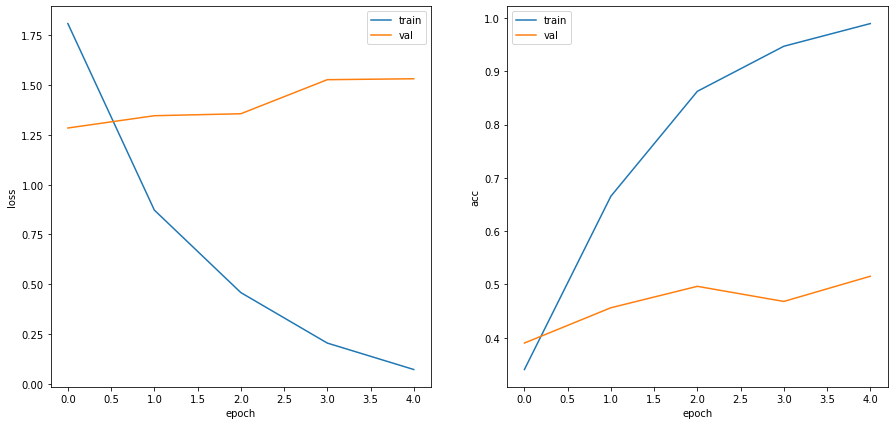

In [11]:
hist = naive_rnn_model_loss_hist.history

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

plt.subplot(1, 2, 2)
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

# Experiment 2: RNN with more layers.

In this experiment, we compare performance of baseline RNN and RNNs with more layers.

In [8]:
# input
rnn_3_lstm_1_dense_input = layers.Input(shape=(22, 1000))

# conv across channels?
p1 = layers.Permute((2, 1))(rnn_3_lstm_1_dense_input)
lstm1 = layers.LSTM(64, return_sequences=True)(p1)
lstm2 = layers.LSTM(64, return_sequences=True)(lstm1)
lstm3 = layers.LSTM(64, return_sequences=True)(lstm2)
f2 = layers.Flatten()(lstm3)
d2 = layers.Dense(64, activation="elu")(f2)

# output
rnn_3_lstm_1_dense_output = layers.Dense(4, activation="softmax")(d2)

# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/rnn_3_lstm_1_dense_1000',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]


rnn_3_lstm_1_dense_model = keras.Model(inputs = rnn_3_lstm_1_dense_input, outputs = rnn_3_lstm_1_dense_output)
rnn_3_lstm_1_dense_model.compile(optimizer="Adam", 
                                 loss="sparse_categorical_crossentropy", 
                                 metrics=["acc"])

rnn_3_lstm_1_dense_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 22, 1000)]        0         
_________________________________________________________________
permute_1 (Permute)          (None, 1000, 22)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1000, 64)          22272     
_________________________________________________________________
lstm_3 (LSTM)                (None, 1000, 64)          33024     
_________________________________________________________________
lstm_4 (LSTM)                (None, 1000, 64)          33024     
_________________________________________________________________
flatten_1 (Flatten)          (None, 64000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                409606

In [13]:
rnn_3_lstm_1_dense_model_loss_hist = rnn_3_lstm_1_dense_model.fit(X_train, y_train,
                                                                  validation_data = (X_valid, y_valid),
                                                                  epochs = 5,
                                                                  callbacks=checkpoint_callback)

Train on 1692 samples, validate on 423 samples
Epoch 1/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.7414 - acc: 0.3329
Epoch 00001: val_loss improved from inf to 1.31247, saving model to ./model_checkpoints/rnn_3_lstm_1_dense_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/rnn_3_lstm_1_dense_1000/assets
1692/1692 [==============================] - 12s 7ms/sample - loss: 1.7362 - acc: 0.3327 - val_loss: 1.3125 - val_acc: 0.3783
Epoch 2/5
1664/1692 [============================>.] - ETA: 0s - loss: 0.9508 - acc: 0.6286
Epoch 00002: val_loss improved from 1.31247 to 1.29895, saving model to ./model_checkpoints/rnn_3_lstm_1_dense_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/rnn_3_lstm_1_dense_1000/assets
1692/1692 [==============================] - 10s 6ms/sample - loss: 0.9541 - acc: 0.6271 - val_loss: 1.2990 - val_acc: 0.4775
Epoch 3/5
1664/1692 [============================>.] - ETA: 0s - loss: 0.6257 - acc: 0.7873
Epoch 00003: val_loss did

In [14]:
# input
rnn_3_lstm_2_dense_input = layers.Input(shape=(22, 1000))

# conv across channels?
p1 = layers.Permute((2, 1))(rnn_3_lstm_2_dense_input)
lstm1 = layers.LSTM(64, return_sequences=True)(p1)
lstm2 = layers.LSTM(64, return_sequences=True)(lstm1)
lstm3 = layers.LSTM(64, return_sequences=True)(lstm2)
f2 = layers.Flatten()(lstm3)
d2 = layers.Dense(64, activation="elu")(f2)
d3 = layers.Dense(64, activation="elu")(d2)


# output
rnn_3_lstm_2_dense_output = layers.Dense(4, activation="softmax")(d3)

# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/rnn_3_lstm_2_dense_1000',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]


rnn_3_lstm_2_dense_model = keras.Model(inputs = rnn_3_lstm_2_dense_input, outputs = rnn_3_lstm_2_dense_output)
rnn_3_lstm_2_dense_model.compile(optimizer="Adam", 
                                 loss="sparse_categorical_crossentropy", 
                                 metrics=["acc"])

rnn_3_lstm_2_dense_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 22, 1000)]        0         
_________________________________________________________________
permute_2 (Permute)          (None, 1000, 22)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 1000, 64)          22272     
_________________________________________________________________
lstm_6 (LSTM)                (None, 1000, 64)          33024     
_________________________________________________________________
lstm_7 (LSTM)                (None, 1000, 64)          33024     
_________________________________________________________________
flatten_2 (Flatten)          (None, 64000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4096

In [15]:
rnn_3_lstm_2_dense_model_loss_hist = rnn_3_lstm_2_dense_model.fit(X_train, y_train,
                                                                  validation_data = (X_valid, y_valid),
                                                                  epochs = 5,
                                                                  callbacks=checkpoint_callback)

Train on 1692 samples, validate on 423 samples
Epoch 1/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.5436 - acc: 0.4014
Epoch 00001: val_loss improved from inf to 1.19305, saving model to ./model_checkpoints/rnn_3_lstm_2_dense_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/rnn_3_lstm_2_dense_1000/assets
1692/1692 [==============================] - 12s 7ms/sample - loss: 1.5364 - acc: 0.4019 - val_loss: 1.1931 - val_acc: 0.4775
Epoch 2/5
1664/1692 [============================>.] - ETA: 0s - loss: 0.8281 - acc: 0.6743
Epoch 00002: val_loss did not improve from 1.19305
1692/1692 [==============================] - 5s 3ms/sample - loss: 0.8233 - acc: 0.6767 - val_loss: 1.2249 - val_acc: 0.4917
Epoch 3/5
1664/1692 [============================>.] - ETA: 0s - loss: 0.4365 - acc: 0.8431
Epoch 00003: val_loss did not improve from 1.19305
1692/1692 [==============================] - 4s 3ms/sample - loss: 0.4389 - acc: 0.8428 - val_loss: 1.4281 - val_acc: 0.5508
E

# Experiment 2 conclusion:

It can be argued, but based on the validation loss dynamics we can say that RNN does not significantly benefit from more layers.

# Experiment 3: augmentation of RNN architecture.

In this experiment, we show how RNN architecture is affected by architecture modifications, such as regularization,  number of hidden units, dropout. We start with dropout ~ 0.3 which is a common solution. Then we try different regularization, adter which variate number of hidden units and then dropout rate.

In [9]:
def construct_rnn_lstm_model(TIME_WINDOW=1000, hidden_units=64, dropout=0, regularizer=0):
    # input
    aug_rnn_input = layers.Input(shape=(22, TIME_WINDOW))

    p1 = layers.Permute((2, 1))(aug_rnn_input)
    lstm1 = layers.LSTM(hidden_units, 
                        return_sequences=True, 
                        dropout=dropout, 
                        kernel_regularizer=keras.regularizers.l2(regularizer))(p1)
    lstm2 = layers.LSTM(hidden_units, 
                        return_sequences=True, 
                        dropout=dropout,
                        kernel_regularizer=keras.regularizers.l2(regularizer))(lstm1)


    f2 = layers.Flatten()(lstm2)
    do2 = layers.Dropout(dropout)(f2)
    elu2 = layers.Dense(hidden_units, activation="elu",  kernel_regularizer=keras.regularizers.l2(regularizer))(do2)

    # output
    aug_rnn_output = layers.Dense(4, activation="softmax")(elu2)
    
    return keras.Model(inputs = aug_rnn_input, outputs = aug_rnn_output)

In [10]:
TIME_WINDOW = 1000
HIDDEN = 64
DROPOUT = 0.3
REGULARIZER = 0.0001

# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/rnn_2_lstm_1_dense_1_conig_1000' ,
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]

rnn_2_lstm_1_dense_64_hidden_03_dropout_00001_reg_1000 = construct_rnn_lstm_model(TIME_WINDOW, 
                                                                                  HIDDEN, 
                                                                                  DROPOUT, 
                                                                                  REGULARIZER)

rnn_2_lstm_1_dense_64_hidden_03_dropout_00001_reg_1000.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

rnn_2_lstm_1_dense_64_hidden_03_dropout_00001_reg_1000.fit(X_train, y_train,
                                                           validation_data = (X_valid, y_valid),
                                                           epochs = 5,
                                                           callbacks=checkpoint_callback)

Train on 1692 samples, validate on 423 samples
Epoch 1/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.7934 - acc: 0.3305
Epoch 00001: val_loss improved from inf to 1.40891, saving model to ./model_checkpoints/rnn_2_lstm_1_dense_1_conig_1000
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./model_checkpoints/rnn_2_lstm_1_dense_1_conig_1000/assets
1692/1692 [==============================] - 10s 6ms/sample - loss: 1.7870 - acc: 0.3316 - val_loss: 1.4089 - val_acc: 0.3286
Epoch 2/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.1302 - acc: 0.5216
Epoch 00002: val_loss improved from 1.40891 to 1.37855, saving model to ./model_checkpoints/rnn_2_lstm_1_dense_1_conig_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/rnn_2_lstm_1_dense_1_conig_1000/assets
1692/1692 [==============================] - 7s 4ms/sample - loss: 1.1333 - acc: 0.5219 - val_loss: 1.3785 - val_acc: 0.4586
Epoch

In [18]:
TIME_WINDOW = 1000
HIDDEN = 64
DROPOUT = 0.3
REGULARIZER = 0.001

# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/rnn_2_lstm_1_dense_2_conig_1000' ,
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]

rnn_2_lstm_1_dense_64_hidden_03_dropout_0001_reg_1000 = construct_rnn_lstm_model(TIME_WINDOW, 
                                                                                 HIDDEN, 
                                                                                 DROPOUT, 
                                                                                 REGULARIZER)

rnn_2_lstm_1_dense_64_hidden_03_dropout_0001_reg_1000.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

rnn_2_lstm_1_dense_64_hidden_03_dropout_0001_reg_1000.fit(X_train, y_train,
                                                           validation_data = (X_valid, y_valid),
                                                           epochs = 5,
                                                           callbacks=checkpoint_callback)

Train on 1692 samples, validate on 423 samples
Epoch 1/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.9654 - acc: 0.3570
Epoch 00001: val_loss improved from inf to 1.62642, saving model to ./model_checkpoints/rnn_2_lstm_1_dense_2_conig_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/rnn_2_lstm_1_dense_2_conig_1000/assets
1692/1692 [==============================] - 9s 5ms/sample - loss: 1.9613 - acc: 0.3576 - val_loss: 1.6264 - val_acc: 0.4397
Epoch 2/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.3425 - acc: 0.6154
Epoch 00002: val_loss did not improve from 1.62642
1692/1692 [==============================] - 3s 2ms/sample - loss: 1.3441 - acc: 0.6141 - val_loss: 1.6350 - val_acc: 0.4586
Epoch 3/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.1136 - acc: 0.7097
Epoch 00003: val_loss did not improve from 1.62642
1692/1692 [==============================] - 3s 2ms/sample - loss: 1.1134 - acc: 0.7098 - val_loss: 1.6568 - va

In [19]:
TIME_WINDOW = 1000
HIDDEN = 64
DROPOUT = 0.3
REGULARIZER = 0.005

# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/rnn_2_lstm_1_dense_3_conig_1000' ,
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]

rnn_2_lstm_1_dense_64_hidden_03_dropout_0005_reg_1000 = construct_rnn_lstm_model(TIME_WINDOW, 
                                                                                 HIDDEN, 
                                                                                 DROPOUT, 
                                                                                 REGULARIZER)

rnn_2_lstm_1_dense_64_hidden_03_dropout_0005_reg_1000.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

rnn_2_lstm_1_dense_64_hidden_03_dropout_0005_reg_1000.fit(X_train, y_train,
                                                           validation_data = (X_valid, y_valid),
                                                           epochs = 5,
                                                           callbacks=checkpoint_callback)

Train on 1692 samples, validate on 423 samples
Epoch 1/5
1664/1692 [============================>.] - ETA: 0s - loss: 3.2333 - acc: 0.3492
Epoch 00001: val_loss improved from inf to 2.74692, saving model to ./model_checkpoints/rnn_2_lstm_1_dense_3_conig_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/rnn_2_lstm_1_dense_3_conig_1000/assets
1692/1692 [==============================] - 9s 5ms/sample - loss: 3.2223 - acc: 0.3522 - val_loss: 2.7469 - val_acc: 0.4350
Epoch 2/5
1664/1692 [============================>.] - ETA: 0s - loss: 2.2790 - acc: 0.5883
Epoch 00002: val_loss improved from 2.74692 to 2.44742, saving model to ./model_checkpoints/rnn_2_lstm_1_dense_3_conig_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/rnn_2_lstm_1_dense_3_conig_1000/assets
1692/1692 [==============================] - 7s 4ms/sample - loss: 2.2834 - acc: 0.5839 - val_loss: 2.4474 - val_acc: 0.4515
Epoch 3/5
1664/1692 [============================>.] - ETA: 0s - loss: 1.8971 - acc: 0.

In [20]:
TIME_WINDOW = 1000
HIDDEN = 64
DROPOUT = 0.3
REGULARIZER = 0.01

# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/rnn_2_lstm_1_dense_3_conig_1000' ,
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]

rnn_2_lstm_1_dense_64_hidden_03_dropout_001_reg_1000 = construct_rnn_lstm_model(TIME_WINDOW, 
                                                                                HIDDEN, 
                                                                                DROPOUT, 
                                                                                REGULARIZER)

rnn_2_lstm_1_dense_64_hidden_03_dropout_001_reg_1000.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

rnn_2_lstm_1_dense_64_hidden_03_dropout_001_reg_1000.fit(X_train, y_train,
                                                         validation_data = (X_valid, y_valid),
                                                         epochs = 5,
                                                         callbacks=checkpoint_callback)

Train on 1692 samples, validate on 423 samples
Epoch 1/5
1664/1692 [============================>.] - ETA: 0s - loss: 4.3282 - acc: 0.3768
Epoch 00001: val_loss improved from inf to 3.50676, saving model to ./model_checkpoints/rnn_2_lstm_1_dense_3_conig_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/rnn_2_lstm_1_dense_3_conig_1000/assets
1692/1692 [==============================] - 9s 5ms/sample - loss: 4.3132 - acc: 0.3800 - val_loss: 3.5068 - val_acc: 0.4350
Epoch 2/5
1664/1692 [============================>.] - ETA: 0s - loss: 2.7595 - acc: 0.6076
Epoch 00002: val_loss improved from 3.50676 to 2.88623, saving model to ./model_checkpoints/rnn_2_lstm_1_dense_3_conig_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/rnn_2_lstm_1_dense_3_conig_1000/assets
1692/1692 [==============================] - 7s 4ms/sample - loss: 2.7542 - acc: 0.6082 - val_loss: 2.8862 - val_acc: 0.4870
Epoch 3/5
1664/1692 [============================>.] - ETA: 0s - loss: 2.3572 - acc: 0.

# NEW EXPERIMENTS HERE

We have to iterate through regularization through range approximately [0.1 - 0.0001], dropout - 0.2-0.5, hidden units - 32 to 128, sampl

In [7]:
from tensorboard.plugins.hparams import api as hp

In [19]:
HP_TIME_WINDOW = hp.HParam('TIME_WINDOW', hp.Discrete([500, 600])) 
HP_BATCH_SIZE = hp.HParam('BATCH_SIZE', hp.Discrete([32])) 
HP_HIDDEN = hp.HParam('HIDDEN', hp.Discrete([64, 128]))
HP_DROPOUT = hp.HParam('DROPOUT', hp.Discrete([0.2, 0.3]))
HP_REGULARIZER = hp.HParam('REGULARIZER', hp.Discrete([.001, .005]))
HP_LEARNING = hp.HParam('LEARNING', hp.Discrete([.00001]))
HP_BETA = hp.HParam('BETA', hp.Discrete([.9]))
VAL_ACCURACY = 'val_accuracy'
TEST_ACCURACY = 'test accuracy'


X_train_norm = X_train - np.mean(X_train)/np.std(X_train)
X_valid_norm = X_valid - np.mean(X_train)/np.std(X_train)
X_test_norm = X_test - np.mean(X_train)/np.std(X_train)

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_TIME_WINDOW, 
#              HP_BATCH_SIZE, 
             HP_HIDDEN, 
             HP_DROPOUT, 
             HP_REGULARIZER, 
#              HP_LEARNING, 
#              HP_BETA
            ],
    metrics=[hp.Metric(VAL_ACCURACY, display_name='Val Accuracy'), 
             hp.Metric(TEST_ACCURACY, display_name='Test Accuracy')],
)

In [9]:
def construct_rnn_lstm_model(hparams):
    # input
    aug_rnn_input = layers.Input(shape=(22, hparams[HP_TIME_WINDOW]))

    p1 = layers.Permute((2, 1))(aug_rnn_input)
    lstm1 = layers.LSTM(hparams[HP_HIDDEN], 
                        return_sequences=True, 
                        dropout=hparams[HP_DROPOUT], 
                        kernel_regularizer=keras.regularizers.l2(hparams[HP_REGULARIZER]),
                        activity_regularizer=keras.regularizers.l2(hparams[HP_REGULARIZER]),
                        recurrent_regularizer=keras.regularizers.l2(hparams[HP_REGULARIZER]))(p1)
    lstm2 = layers.LSTM(hparams[HP_HIDDEN], 
                        return_sequences=True, 
                        dropout=hparams[HP_DROPOUT],
                        kernel_regularizer=keras.regularizers.l2(hparams[HP_REGULARIZER]),
                        activity_regularizer=keras.regularizers.l2(hparams[HP_REGULARIZER]),
                        recurrent_regularizer=keras.regularizers.l2(hparams[HP_REGULARIZER]))(lstm1)


    f2 = layers.Flatten()(lstm2)
    do2 = layers.Dropout(hparams[HP_DROPOUT])(f2)
    elu2 = layers.Dense(hparams[HP_HIDDEN], activation="elu",  kernel_regularizer=keras.regularizers.l2(hparams[HP_REGULARIZER]))(do2)

    # output
    aug_rnn_output = layers.Dense(4, activation="softmax")(elu2)
    
    return keras.Model(inputs = aug_rnn_input, outputs = aug_rnn_output)

In [10]:
# save model with the best accuracy 
# checkpoint_callback = [
#     keras.callbacks.ModelCheckpoint(
#         filepath='./model_checkpoints/rnn_lstm_model' ,
#         # Path where to save the model
#         # The two parameters below mean that we will overwrite
#         # the current checkpoint if and only if
#         # the `val_loss` score has improved.
#         save_best_only=True,
#         monitor='val_loss',
#         verbose=1)
# ]

def train_test_rnn_lstm_model(hparams):
    rnn_lstm_model = construct_rnn_lstm_model(hparams)
    
    adam = keras.optimizers.Adam(learning_rate=hparams[HP_LEARNING], beta_1=hparams[HP_BETA])

    rnn_lstm_model.compile(optimizer=adam, loss="sparse_categorical_crossentropy", metrics=["acc"])
    rnn_lstm_model.summary()
    hist = rnn_lstm_model.fit(X_train_slices, y_train_slices, validation_data = (X_valid_slices, y_valid_slices), 
                              epochs = 100, 
#                               callbacks=checkpoint_callback, 
                              batch_size=hparams[HP_BATCH_SIZE]).history
    _, accuracy = rnn_lstm_model.evaluate(X_test_slices, y_test_slices)
    return accuracy, hist, rnn_lstm_model


def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    test_accuracy, hist, model = train_test_rnn_lstm_model(hparams)
    tf.summary.scalar(VAL_ACCURACY, max(hist['val_acc']), step=1)
    tf.summary.scalar(TEST_ACCURACY, test_accuracy, step=1)
  return model

In [11]:
session_num = 0
TIME_STRIDE = 1000
for window_size in HP_TIME_WINDOW.domain.values:
            
    X_train_slices, y_train_slices = sliding_window(X_train_norm, 
                                                    y_train, 
                                                    time_window=window_size,  
                                                    time_stride=TIME_STRIDE)


    X_valid_slices, y_valid_slices = sliding_window(X_valid_norm, 
                                                    y_valid, 
                                                    time_window=window_size, 
                                                    time_stride=TIME_STRIDE)

    X_test_slices, y_test_slices = sliding_window(X_test_norm, 
                                                    y_test, 
                                                    time_window=window_size, 
                                                    time_stride=TIME_STRIDE)

    print("Training data shape with slices: {}".format(X_train_slices.shape))
    print("Training label shape with slice: {}".format(y_train_slices.shape))
    print("Validation data shape with slices: {}".format(X_valid_slices.shape))
    print("Validation label shape with slice: {}".format(y_valid_slices.shape))
    print("Testing data shape with slices: {}".format(X_test_slices.shape))
    print("Testing label shape with slice: {}".format(y_test_slices.shape))
    for num_units in HP_HIDDEN.domain.values:
        for batch_size in HP_BATCH_SIZE.domain.values:
            for dropout_rate in HP_DROPOUT.domain.values:
                for reg in HP_REGULARIZER.domain.values:
                    for learning_rate in HP_LEARNING.domain.values:
                        for beta in HP_BETA.domain.values:
                            hparams = {
                                HP_TIME_WINDOW: window_size,
                                HP_BATCH_SIZE: batch_size,
                                HP_HIDDEN: num_units,
                                HP_DROPOUT: dropout_rate,
                                HP_REGULARIZER: reg,
                                HP_LEARNING: learning_rate,
                                HP_BETA: beta,
                            }

                            run_name = "run-%d" % session_num
                            print('--- Starting trial: %s' % run_name)
                            print({h.name: hparams[h] for h in hparams})
                            model = run('logs/hparam_tuning/' + run_name, hparams)
                            session_num += 1


Training data shape with slices: (1692, 22, 500)
Training label shape with slice: (1692,)
Validation data shape with slices: (423, 22, 500)
Validation label shape with slice: (423,)
Testing data shape with slices: (443, 22, 500)
Testing label shape with slice: (443,)
--- Starting trial: run-0
{'TIME_WINDOW': 500, 'BATCH_SIZE': 32, 'HIDDEN': 64, 'DROPOUT': 0.2, 'REGULARIZER': 0.001, 'LEARNING': 1e-05, 'BETA': 0.9}
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 22, 500)]         0         
_________________________________________________________________
permute (Permute)            (None, 500, 22)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 500, 64)           22272     
_________________________________________________________________
lstm_1 (LSTM)                (None, 500,

Epoch 47/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 3.3664 - acc: 0.8008 - val_loss: 3.5589 - val_acc: 0.5626
Epoch 48/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 3.3213 - acc: 0.8002 - val_loss: 3.5223 - val_acc: 0.5650
Epoch 49/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 3.2935 - acc: 0.7949 - val_loss: 3.4866 - val_acc: 0.5626
Epoch 50/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 3.2399 - acc: 0.8026 - val_loss: 3.4481 - val_acc: 0.5626
Epoch 51/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 3.2210 - acc: 0.8038 - val_loss: 3.4120 - val_acc: 0.5650
Epoch 52/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 3.1799 - acc: 0.7991 - val_loss: 3.3791 - val_acc: 0.5626
Epoch 53/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 3.1358 - acc: 0.8020 - val_loss: 3.3494 - val_acc: 0.5626
Epoch 54/100
1692/1692 [==========

1692/1692 [==============================] - 4s 2ms/sample - loss: 33.7683 - acc: 0.2937 - val_loss: 35.6872 - val_acc: 0.3215
Epoch 2/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 32.7042 - acc: 0.3676 - val_loss: 34.5190 - val_acc: 0.3853
Epoch 3/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 31.7281 - acc: 0.4527 - val_loss: 33.4712 - val_acc: 0.4066
Epoch 4/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 30.8328 - acc: 0.4929 - val_loss: 32.4865 - val_acc: 0.4184
Epoch 5/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 30.0092 - acc: 0.5443 - val_loss: 31.5788 - val_acc: 0.4515
Epoch 6/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 29.2091 - acc: 0.5556 - val_loss: 30.7079 - val_acc: 0.4634
Epoch 7/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 28.4583 - acc: 0.5792 - val_loss: 29.8665 - val_acc: 0.4563
Epoch 8/100
1692/1692 [================

1692/1692 [==============================] - 2s 1ms/sample - loss: 10.2897 - acc: 0.7701 - val_loss: 9.7910 - val_acc: 0.5343
Epoch 60/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 10.1341 - acc: 0.7748 - val_loss: 9.6554 - val_acc: 0.5272
Epoch 61/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 9.9973 - acc: 0.7748 - val_loss: 9.5245 - val_acc: 0.5272
Epoch 62/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 9.8641 - acc: 0.7866 - val_loss: 9.3961 - val_acc: 0.5201
Epoch 63/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 9.7395 - acc: 0.7583 - val_loss: 9.2741 - val_acc: 0.5201
Epoch 64/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 9.5946 - acc: 0.7671 - val_loss: 9.1538 - val_acc: 0.5225
Epoch 65/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 9.4879 - acc: 0.7665 - val_loss: 9.0380 - val_acc: 0.5343
Epoch 66/100
1692/1692 [=====================

1692/1692 [==============================] - 2s 1ms/sample - loss: 6.8336 - acc: 0.4882 - val_loss: 7.3063 - val_acc: 0.4184
Epoch 7/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 6.6692 - acc: 0.5189 - val_loss: 7.1206 - val_acc: 0.4468
Epoch 8/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 6.5232 - acc: 0.5355 - val_loss: 6.9426 - val_acc: 0.4515
Epoch 9/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 6.3833 - acc: 0.5520 - val_loss: 6.7737 - val_acc: 0.4610
Epoch 10/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 6.2555 - acc: 0.5691 - val_loss: 6.6092 - val_acc: 0.4752
Epoch 11/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 6.1217 - acc: 0.5816 - val_loss: 6.4574 - val_acc: 0.4941
Epoch 12/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 6.0044 - acc: 0.6011 - val_loss: 6.3174 - val_acc: 0.4870
Epoch 13/100
1692/1692 [==========================

1692/1692 [==============================] - 2s 1ms/sample - loss: 2.9878 - acc: 0.7470 - val_loss: 3.1503 - val_acc: 0.5296
Epoch 66/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.9592 - acc: 0.7459 - val_loss: 3.1268 - val_acc: 0.5366
Epoch 67/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.9419 - acc: 0.7411 - val_loss: 3.1042 - val_acc: 0.5319
Epoch 68/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.9142 - acc: 0.7530 - val_loss: 3.0826 - val_acc: 0.5414
Epoch 69/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.8983 - acc: 0.7376 - val_loss: 3.0610 - val_acc: 0.5343
Epoch 70/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.8553 - acc: 0.7530 - val_loss: 3.0399 - val_acc: 0.5390
Epoch 71/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.8359 - acc: 0.7553 - val_loss: 3.0190 - val_acc: 0.5414
Epoch 72/100
1692/1692 [=======================

1692/1692 [==============================] - 2s 1ms/sample - loss: 26.0262 - acc: 0.6117 - val_loss: 26.8992 - val_acc: 0.4515
Epoch 13/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 25.4273 - acc: 0.6188 - val_loss: 26.1630 - val_acc: 0.4610
Epoch 14/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 24.8708 - acc: 0.6306 - val_loss: 25.4464 - val_acc: 0.4681
Epoch 15/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 24.3182 - acc: 0.6200 - val_loss: 24.7623 - val_acc: 0.4704
Epoch 16/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 23.7822 - acc: 0.6495 - val_loss: 24.0987 - val_acc: 0.4728
Epoch 17/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 23.2610 - acc: 0.6241 - val_loss: 23.4546 - val_acc: 0.4775
Epoch 18/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 22.7513 - acc: 0.6383 - val_loss: 22.8379 - val_acc: 0.4823
Epoch 19/100
1692/1692 [=========

Epoch 71/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 9.4326 - acc: 0.7051 - val_loss: 8.4371 - val_acc: 0.5508
Epoch 72/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 9.3079 - acc: 0.7110 - val_loss: 8.3360 - val_acc: 0.5485
Epoch 73/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 9.2023 - acc: 0.6980 - val_loss: 8.2388 - val_acc: 0.5461
Epoch 74/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 9.0984 - acc: 0.7145 - val_loss: 8.1435 - val_acc: 0.5437
Epoch 75/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 8.9910 - acc: 0.6909 - val_loss: 8.0500 - val_acc: 0.5414
Epoch 76/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 8.8726 - acc: 0.7092 - val_loss: 7.9588 - val_acc: 0.5414
Epoch 77/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 8.7796 - acc: 0.7122 - val_loss: 7.8663 - val_acc: 0.5461
Epoch 78/100
1692/1692 [==========

1692/1692 [==============================] - 2s 1ms/sample - loss: 7.3890 - acc: 0.8682 - val_loss: 7.6299 - val_acc: 0.5697
Epoch 19/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 7.1975 - acc: 0.8676 - val_loss: 7.4404 - val_acc: 0.5721
Epoch 20/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 7.0278 - acc: 0.8753 - val_loss: 7.2442 - val_acc: 0.5650
Epoch 21/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 6.8576 - acc: 0.8682 - val_loss: 7.0612 - val_acc: 0.5745
Epoch 22/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 6.7006 - acc: 0.8694 - val_loss: 6.8934 - val_acc: 0.5556
Epoch 23/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 6.5465 - acc: 0.8688 - val_loss: 6.7351 - val_acc: 0.5626
Epoch 24/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 6.3871 - acc: 0.8853 - val_loss: 6.5874 - val_acc: 0.5603
Epoch 25/100
1692/1692 [=======================

1692/1692 [==============================] - 2s 1ms/sample - loss: 3.0023 - acc: 0.9515 - val_loss: 3.5619 - val_acc: 0.5697
Epoch 78/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.9829 - acc: 0.9486 - val_loss: 3.5409 - val_acc: 0.5674
Epoch 79/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.9512 - acc: 0.9521 - val_loss: 3.5140 - val_acc: 0.5674
Epoch 80/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.9311 - acc: 0.9498 - val_loss: 3.5068 - val_acc: 0.5674
Epoch 81/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.9043 - acc: 0.9433 - val_loss: 3.4821 - val_acc: 0.5674
Epoch 82/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.8783 - acc: 0.9456 - val_loss: 3.4597 - val_acc: 0.5674
Epoch 83/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.8516 - acc: 0.9527 - val_loss: 3.4456 - val_acc: 0.5626
Epoch 84/100
1692/1692 [=======================

Epoch 24/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 27.8965 - acc: 0.8688 - val_loss: 26.0171 - val_acc: 0.5697
Epoch 25/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 27.1697 - acc: 0.8706 - val_loss: 25.2650 - val_acc: 0.5768
Epoch 26/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 26.4630 - acc: 0.8788 - val_loss: 24.5522 - val_acc: 0.5768
Epoch 27/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 25.7864 - acc: 0.8812 - val_loss: 23.8807 - val_acc: 0.5721
Epoch 28/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 25.1715 - acc: 0.8759 - val_loss: 23.2490 - val_acc: 0.5768
Epoch 29/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 24.5697 - acc: 0.8729 - val_loss: 22.6463 - val_acc: 0.5745
Epoch 30/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 23.9822 - acc: 0.8794 - val_loss: 22.0786 - val_acc: 0.5721
Epoch 31/100
1692/16

1692/1692 [==============================] - 2s 1ms/sample - loss: 10.2238 - acc: 0.9048 - val_loss: 9.5783 - val_acc: 0.5792
Epoch 83/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 10.1085 - acc: 0.9096 - val_loss: 9.4658 - val_acc: 0.5816
Epoch 84/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 10.0004 - acc: 0.9001 - val_loss: 9.3653 - val_acc: 0.5863
Epoch 85/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 9.8785 - acc: 0.9060 - val_loss: 9.2657 - val_acc: 0.5863
Epoch 86/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 9.7614 - acc: 0.9054 - val_loss: 9.1642 - val_acc: 0.5816
Epoch 87/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 9.6559 - acc: 0.8983 - val_loss: 9.0636 - val_acc: 0.5792
Epoch 88/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 9.5407 - acc: 0.8960 - val_loss: 8.9641 - val_acc: 0.5792
Epoch 89/100
1692/1692 [====================

1692/1692 [==============================] - 2s 1ms/sample - loss: 6.3130 - acc: 0.8333 - val_loss: 6.2257 - val_acc: 0.5745
Epoch 30/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 6.1954 - acc: 0.8351 - val_loss: 6.1167 - val_acc: 0.5816
Epoch 31/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 6.0809 - acc: 0.8410 - val_loss: 5.9910 - val_acc: 0.5768
Epoch 32/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 5.9738 - acc: 0.8310 - val_loss: 5.8930 - val_acc: 0.5721
Epoch 33/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 5.8755 - acc: 0.8245 - val_loss: 5.7910 - val_acc: 0.5792
Epoch 34/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 5.7649 - acc: 0.8381 - val_loss: 5.6818 - val_acc: 0.5721
Epoch 35/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 5.6748 - acc: 0.8339 - val_loss: 5.5865 - val_acc: 0.5745
Epoch 36/100
1692/1692 [=======================

1692/1692 [==============================] - 2s 1ms/sample - loss: 3.0553 - acc: 0.8978 - val_loss: 3.4238 - val_acc: 0.6052
Epoch 89/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 3.0257 - acc: 0.9048 - val_loss: 3.4010 - val_acc: 0.6028
Epoch 90/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 3.0024 - acc: 0.9031 - val_loss: 3.3883 - val_acc: 0.6028
Epoch 91/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.9835 - acc: 0.8978 - val_loss: 3.3701 - val_acc: 0.5981
Epoch 92/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.9752 - acc: 0.8907 - val_loss: 3.3640 - val_acc: 0.5934
Epoch 93/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.9501 - acc: 0.8918 - val_loss: 3.3448 - val_acc: 0.5957
Epoch 94/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.9095 - acc: 0.9131 - val_loss: 3.3241 - val_acc: 0.5934
Epoch 95/100
1692/1692 [=======================

Epoch 35/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 22.1031 - acc: 0.8227 - val_loss: 19.3468 - val_acc: 0.6052
Epoch 36/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 21.6299 - acc: 0.8156 - val_loss: 18.9180 - val_acc: 0.6052
Epoch 37/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 21.1823 - acc: 0.8292 - val_loss: 18.5102 - val_acc: 0.6099
Epoch 38/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 20.7687 - acc: 0.8191 - val_loss: 18.1220 - val_acc: 0.5934
Epoch 39/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 20.3596 - acc: 0.8322 - val_loss: 17.7432 - val_acc: 0.6099
Epoch 40/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 19.9670 - acc: 0.8109 - val_loss: 17.3892 - val_acc: 0.5957
Epoch 41/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 19.5886 - acc: 0.8126 - val_loss: 17.0451 - val_acc: 0.6052
Epoch 42/100
1692/16

1692/1692 [==============================] - 2s 1ms/sample - loss: 9.4541 - acc: 0.8410 - val_loss: 8.4065 - val_acc: 0.6099
Epoch 94/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 9.3576 - acc: 0.8357 - val_loss: 8.3198 - val_acc: 0.6170
Epoch 95/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 9.2610 - acc: 0.8345 - val_loss: 8.2417 - val_acc: 0.6052
Epoch 96/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 9.1808 - acc: 0.8191 - val_loss: 8.1609 - val_acc: 0.6099
Epoch 97/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 9.0672 - acc: 0.8381 - val_loss: 8.0777 - val_acc: 0.6052
Epoch 98/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 8.9660 - acc: 0.8375 - val_loss: 7.9956 - val_acc: 0.6099
Epoch 99/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 8.8806 - acc: 0.8398 - val_loss: 7.9195 - val_acc: 0.6123
Epoch 100/100
443/443 [========================

1692/1692 [==============================] - 2s 1ms/sample - loss: 4.4274 - acc: 0.8067 - val_loss: 4.6134 - val_acc: 0.5248
Epoch 39/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 4.3624 - acc: 0.8239 - val_loss: 4.5499 - val_acc: 0.5225
Epoch 40/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 4.3063 - acc: 0.8197 - val_loss: 4.4894 - val_acc: 0.5272
Epoch 41/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 4.2629 - acc: 0.7967 - val_loss: 4.4308 - val_acc: 0.5296
Epoch 42/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 4.1929 - acc: 0.8251 - val_loss: 4.3732 - val_acc: 0.5343
Epoch 43/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 4.1380 - acc: 0.8191 - val_loss: 4.3195 - val_acc: 0.5343
Epoch 44/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 4.0754 - acc: 0.8333 - val_loss: 4.2689 - val_acc: 0.5366
Epoch 45/100
1692/1692 [=======================

1692/1692 [==============================] - 2s 1ms/sample - loss: 2.4620 - acc: 0.8735 - val_loss: 2.8971 - val_acc: 0.5650
Epoch 98/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.4467 - acc: 0.8753 - val_loss: 2.8871 - val_acc: 0.5674
Epoch 99/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 2.4337 - acc: 0.8747 - val_loss: 2.8768 - val_acc: 0.5697
Epoch 100/100
443/443 [==============================] - 0s 476us/sample - loss: 2.8895 - acc: 0.5214
--- Starting trial: run-9
{'TIME_WINDOW': 600, 'BATCH_SIZE': 32, 'HIDDEN': 64, 'DROPOUT': 0.2, 'REGULARIZER': 0.005, 'LEARNING': 1e-05, 'BETA': 0.9}
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 22, 600)]         0         
_________________________________________________________________
permute_9 (Permute)          (None, 600, 22)           0         
_

1692/1692 [==============================] - 2s 1ms/sample - loss: 16.3197 - acc: 0.8061 - val_loss: 15.7292 - val_acc: 0.5225
Epoch 44/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 16.0379 - acc: 0.8079 - val_loss: 15.4297 - val_acc: 0.5201
Epoch 45/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 15.7540 - acc: 0.7890 - val_loss: 15.1372 - val_acc: 0.5177
Epoch 46/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 15.4876 - acc: 0.7931 - val_loss: 14.8599 - val_acc: 0.5201
Epoch 47/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 15.2146 - acc: 0.8209 - val_loss: 14.5871 - val_acc: 0.5272
Epoch 48/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 14.9503 - acc: 0.8085 - val_loss: 14.3302 - val_acc: 0.5390
Epoch 49/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 14.7004 - acc: 0.8174 - val_loss: 14.0810 - val_acc: 0.5390
Epoch 50/100
1692/1692 [=========

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 22, 600)]         0         
_________________________________________________________________
permute_10 (Permute)         (None, 600, 22)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 600, 64)           22272     
_________________________________________________________________
lstm_21 (LSTM)               (None, 600, 64)           33024     
_________________________________________________________________
flatten_10 (Flatten)         (None, 38400)             0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 38400)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                245

Epoch 50/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 3.9930 - acc: 0.7423 - val_loss: 4.1361 - val_acc: 0.5319
Epoch 51/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 3.9381 - acc: 0.7530 - val_loss: 4.0902 - val_acc: 0.5296
Epoch 52/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 3.8894 - acc: 0.7719 - val_loss: 4.0464 - val_acc: 0.5272
Epoch 53/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 3.8286 - acc: 0.7642 - val_loss: 4.0034 - val_acc: 0.5366
Epoch 54/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 3.8061 - acc: 0.7530 - val_loss: 3.9602 - val_acc: 0.5414
Epoch 55/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 3.7378 - acc: 0.7677 - val_loss: 3.9229 - val_acc: 0.5366
Epoch 56/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 3.7084 - acc: 0.7719 - val_loss: 3.8852 - val_acc: 0.5225
Epoch 57/100
1692/1692 [==========

1692/1692 [==============================] - 4s 2ms/sample - loss: 37.8056 - acc: 0.2730 - val_loss: 41.2096 - val_acc: 0.3570
Epoch 2/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 36.7446 - acc: 0.3676 - val_loss: 39.8325 - val_acc: 0.4113
Epoch 3/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 35.7546 - acc: 0.4326 - val_loss: 38.5685 - val_acc: 0.4232
Epoch 4/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 34.8607 - acc: 0.4645 - val_loss: 37.3923 - val_acc: 0.4421
Epoch 5/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 33.9796 - acc: 0.5266 - val_loss: 36.2908 - val_acc: 0.4563
Epoch 6/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 33.1792 - acc: 0.5331 - val_loss: 35.2545 - val_acc: 0.4421
Epoch 7/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 32.3890 - acc: 0.5632 - val_loss: 34.2636 - val_acc: 0.4492
Epoch 8/100
1692/1692 [================

1692/1692 [==============================] - 2s 1ms/sample - loss: 12.5304 - acc: 0.7465 - val_loss: 11.3045 - val_acc: 0.5225
Epoch 60/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 12.3496 - acc: 0.7411 - val_loss: 11.1393 - val_acc: 0.5248
Epoch 61/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 12.1662 - acc: 0.7435 - val_loss: 10.9789 - val_acc: 0.5225
Epoch 62/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 12.0090 - acc: 0.7429 - val_loss: 10.8223 - val_acc: 0.5201
Epoch 63/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 11.8407 - acc: 0.7423 - val_loss: 10.6697 - val_acc: 0.5154
Epoch 64/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 11.6770 - acc: 0.7423 - val_loss: 10.5186 - val_acc: 0.5106
Epoch 65/100
1692/1692 [==============================] - 2s 1ms/sample - loss: 11.5239 - acc: 0.7465 - val_loss: 10.3734 - val_acc: 0.5083
Epoch 66/100
1692/1692 [=========

Epoch 6/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 12.1932 - acc: 0.7476 - val_loss: 12.6784 - val_acc: 0.5035
Epoch 7/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 11.7298 - acc: 0.7612 - val_loss: 12.1671 - val_acc: 0.5366
Epoch 8/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 11.3165 - acc: 0.7866 - val_loss: 11.7227 - val_acc: 0.5366
Epoch 9/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 10.9160 - acc: 0.8091 - val_loss: 11.3019 - val_acc: 0.5390
Epoch 10/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 10.5577 - acc: 0.8109 - val_loss: 10.9039 - val_acc: 0.5390
Epoch 11/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 10.2074 - acc: 0.8369 - val_loss: 10.5378 - val_acc: 0.5437
Epoch 12/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 9.8774 - acc: 0.8410 - val_loss: 10.1923 - val_acc: 0.5414
Epoch 13/100
1692/1692 [=

1692/1692 [==============================] - 3s 2ms/sample - loss: 3.5884 - acc: 0.9545 - val_loss: 4.0432 - val_acc: 0.5650
Epoch 66/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 3.5522 - acc: 0.9504 - val_loss: 4.0051 - val_acc: 0.5674
Epoch 67/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 3.5046 - acc: 0.9657 - val_loss: 3.9729 - val_acc: 0.5697
Epoch 68/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 3.4756 - acc: 0.9533 - val_loss: 3.9506 - val_acc: 0.5626
Epoch 69/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 3.4334 - acc: 0.9527 - val_loss: 3.9254 - val_acc: 0.5603
Epoch 70/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 3.4039 - acc: 0.9557 - val_loss: 3.8899 - val_acc: 0.5626
Epoch 71/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 3.3582 - acc: 0.9610 - val_loss: 3.8609 - val_acc: 0.5650
Epoch 72/100
1692/1692 [=======================

1692/1692 [==============================] - 3s 2ms/sample - loss: 47.2202 - acc: 0.8599 - val_loss: 47.0146 - val_acc: 0.5839
Epoch 13/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 45.6552 - acc: 0.8664 - val_loss: 45.2291 - val_acc: 0.5839
Epoch 14/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 44.1430 - acc: 0.8765 - val_loss: 43.5323 - val_acc: 0.5887
Epoch 15/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 42.7341 - acc: 0.8830 - val_loss: 41.9193 - val_acc: 0.5839
Epoch 16/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 41.3680 - acc: 0.8978 - val_loss: 40.3910 - val_acc: 0.5839
Epoch 17/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 40.0719 - acc: 0.8913 - val_loss: 38.9378 - val_acc: 0.5957
Epoch 18/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 38.8319 - acc: 0.9066 - val_loss: 37.5480 - val_acc: 0.5957
Epoch 19/100
1692/1692 [=========

1692/1692 [==============================] - 3s 2ms/sample - loss: 13.1767 - acc: 0.9356 - val_loss: 12.1571 - val_acc: 0.5934
Epoch 71/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 12.9921 - acc: 0.9267 - val_loss: 11.9913 - val_acc: 0.5934
Epoch 72/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 12.8286 - acc: 0.9261 - val_loss: 11.8218 - val_acc: 0.6028
Epoch 73/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 12.6447 - acc: 0.9362 - val_loss: 11.6621 - val_acc: 0.6005
Epoch 74/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 12.4725 - acc: 0.9208 - val_loss: 11.5097 - val_acc: 0.5981
Epoch 75/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 12.3033 - acc: 0.9267 - val_loss: 11.3510 - val_acc: 0.5981
Epoch 76/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 12.1349 - acc: 0.9374 - val_loss: 11.2004 - val_acc: 0.6028
Epoch 77/100
1692/1692 [=========

Epoch 17/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 8.9627 - acc: 0.8215 - val_loss: 8.9057 - val_acc: 0.5579
Epoch 18/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 8.7542 - acc: 0.8180 - val_loss: 8.6659 - val_acc: 0.5579
Epoch 19/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 8.5375 - acc: 0.8227 - val_loss: 8.4409 - val_acc: 0.5603
Epoch 20/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 8.3536 - acc: 0.8375 - val_loss: 8.2252 - val_acc: 0.5508
Epoch 21/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 8.1580 - acc: 0.8357 - val_loss: 8.0159 - val_acc: 0.5674
Epoch 22/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 7.9705 - acc: 0.8410 - val_loss: 7.8028 - val_acc: 0.5839
Epoch 23/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 7.7997 - acc: 0.8475 - val_loss: 7.6320 - val_acc: 0.5579
Epoch 24/100
1692/1692 [==========

1692/1692 [==============================] - 3s 2ms/sample - loss: 3.5316 - acc: 0.8983 - val_loss: 3.8189 - val_acc: 0.6028
Epoch 77/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 3.4961 - acc: 0.8978 - val_loss: 3.8024 - val_acc: 0.5934
Epoch 78/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 3.4593 - acc: 0.9090 - val_loss: 3.7790 - val_acc: 0.5957
Epoch 79/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 3.4261 - acc: 0.9043 - val_loss: 3.7612 - val_acc: 0.5768
Epoch 80/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 3.3918 - acc: 0.9060 - val_loss: 3.7355 - val_acc: 0.5910
Epoch 81/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 3.3679 - acc: 0.9066 - val_loss: 3.7071 - val_acc: 0.5934
Epoch 82/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 3.3441 - acc: 0.9043 - val_loss: 3.6904 - val_acc: 0.6005
Epoch 83/100
1692/1692 [=======================

Epoch 23/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 34.7516 - acc: 0.8511 - val_loss: 32.1270 - val_acc: 0.5792
Epoch 24/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 33.8743 - acc: 0.8387 - val_loss: 31.1411 - val_acc: 0.5863
Epoch 25/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 33.0316 - acc: 0.8316 - val_loss: 30.2074 - val_acc: 0.5910
Epoch 26/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 32.2016 - acc: 0.8221 - val_loss: 29.3274 - val_acc: 0.5981
Epoch 27/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 31.3884 - acc: 0.8310 - val_loss: 28.4951 - val_acc: 0.5910
Epoch 28/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 30.6465 - acc: 0.8398 - val_loss: 27.7062 - val_acc: 0.5957
Epoch 29/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 29.9433 - acc: 0.8404 - val_loss: 26.9551 - val_acc: 0.5887
Epoch 30/100
1692/16

1692/1692 [==============================] - 3s 2ms/sample - loss: 12.4748 - acc: 0.8593 - val_loss: 10.8816 - val_acc: 0.6028
Epoch 82/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 12.3178 - acc: 0.8688 - val_loss: 10.7504 - val_acc: 0.6028
Epoch 83/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 12.1712 - acc: 0.8564 - val_loss: 10.6244 - val_acc: 0.5981
Epoch 84/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 12.0292 - acc: 0.8605 - val_loss: 10.4995 - val_acc: 0.6076
Epoch 85/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 11.8933 - acc: 0.8641 - val_loss: 10.3765 - val_acc: 0.6005
Epoch 86/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 11.7567 - acc: 0.8570 - val_loss: 10.2585 - val_acc: 0.6005
Epoch 87/100
1692/1692 [==============================] - 3s 2ms/sample - loss: 11.6038 - acc: 0.8641 - val_loss: 10.1445 - val_acc: 0.5934
Epoch 88/100
1692/1692 [=========

In [35]:
model.fit(X_train_slices, y_train_slices, validation_data = (X_valid_slices, y_valid_slices), epochs = 20, callbacks=checkpoint_callback)

Train on 1692 samples, validate on 423 samples
Epoch 1/20
1632/1692 [===========================>..] - ETA: 0s - loss: 1.7484 - acc: 0.9688
Epoch 00001: val_loss improved from 2.60234 to 2.59535, saving model to ./model_checkpoints/rnn_lstm_model
INFO:tensorflow:Assets written to: ./model_checkpoints/rnn_lstm_model/assets
1692/1692 [==============================] - 8s 5ms/sample - loss: 1.7491 - acc: 0.9675 - val_loss: 2.5953 - val_acc: 0.5745
Epoch 2/20
1664/1692 [============================>.] - ETA: 0s - loss: 1.7476 - acc: 0.9645
Epoch 00002: val_loss improved from 2.59535 to 2.59124, saving model to ./model_checkpoints/rnn_lstm_model
INFO:tensorflow:Assets written to: ./model_checkpoints/rnn_lstm_model/assets
1692/1692 [==============================] - 8s 4ms/sample - loss: 1.7472 - acc: 0.9645 - val_loss: 2.5912 - val_acc: 0.5816
Epoch 3/20
1664/1692 [============================>.] - ETA: 0s - loss: 1.7467 - acc: 0.9579
Epoch 00003: val_loss did not improve from 2.59124
1692/

In [18]:
%reload_ext tensorboard
%tensorboard --logdir logs/hparam_tuning

In [17]:
!kill 4696

## Get accuracies

In [ ]:
best_shallow_model_300 = keras.models.load_model('./model_checkpoints/shallow_model_300')
best_shallow_model_500 = keras.models.load_model('./model_checkpoints/shallow_model_500')
best_shallow_model_600 = keras.models.load_model('./model_checkpoints/shallow_model_600')
best_shallow_model_700 = keras.models.load_model('./model_checkpoints/shallow_model_700')
best_shallow_model_800 = keras.models.load_model('./model_checkpoints/shallow_model_800')
best_shallow_model_900 = keras.models.load_model('./model_checkpoints/shallow_model_900')
best_shallow_model_1000 = keras.models.load_model('./model_checkpoints/shallow_model_1000')

accuracies.append(best_shallow_model_1000.evaluate(X_valid_slices, y_valid_slices)[1])


# Augmented RNN model

It is clear that naive RNN model suffers from overfit - training loss of the model continues to drop while validation loss saturates and accuracy does not go beyond 50%. This can be fixed in 3 ways - dataset augmentation, architecture improvements and regularization.

1. Architecture improvements: add dropouts to our layers; try GRU instead of LSTM;
2. Dataset augmentation: normilize inputs, decrease the length of the example and upsample using sliding window approach - that produces correlation between examples, but if traning/validation/test sets are separated beforehand, that should be fine.
3. Regularizations: 

Results:

1. Dropout layers do not help to improve accuracy. It stays around 45% anyway
2. Augmentation allowed to achieve validation accuracy of 55% and test accuracy of 50% if std not squared. Trained for 2 epoch. If std is squared, 2 epochs give 52% validation and 50% test. After this accuracy satruates. From this moment on all data is presumed to be normilized without square.
3. Usage of sliding window lead to dramatic decrease of accuracy. From this point on it is assumed that no sliding wndow is applied.
4. a) With length of 1000 we can achieve 56% validation 54% test over 5 epochs. After this learning saturates.
4. b) Decrease of the length to 800 allowed to achieve 58% validation 55% test over 5 epochs. After this learning saturates.
4. c) Decrease of the length to 750 allowed to achieve 59% validation 53% test over 3 epochs. After this learning saturates. 
4. d) Decrease of the length to 600 allowed to achieve 65% validation 57% test over 5 epochs. After this learning saturates. 
4. e) Overall, the gain from smaller window is also small +/- 3% at best. This is why from now we will rn experiments with 1000 but in the end also try 750%.

5. When network starts to overfit you can decrease learning rate to 1e-4 to get a couple of additional persents.
6. Form this point on we use size of 1000 samples per example if reverse is not specified.
7. a) Added regularization to hidden layer of 0.001. Validation 56% test 53%
7. b) Added regularization to hidden layer of 0.1.

# Results

In [ ]:
aug_rnn_model_results = aug_rnn_model.evaluate(X_test_slices, y_test_slices)

print('RNN model test loss:', aug_rnn_model_results[0])
print('RNN model test acc:', aug_rnn_model_results[1])